# Additional Features and Aggregates

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os

## Loading data

In [2]:
input_file_name = "merged.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

data = pd.read_csv(input_file_path, index_col=0, parse_dates=True, engine='c')
data.head()
data.iloc[0:3,-10:]

,rh_termin,rh,rhmin,rhmax,padavine,veter_hitrost,veter_vek_smer,veter_max_hitrost,energija_gl,energija_di
2011-01-01 00:30:00,95,95,95,95,0,1.3,100,1.90,0,0
2011-01-01 00:45:00,95,95,95,95,0,1.0,102,1.65,0,0
2011-01-01 01:00:00,95,95,95,95,0,0.7,104,1.40,0,0


## Removing unnecessary fields

In [3]:
dropFields = ['pmin', 'pmax', 't2m', 't2mmin', 't2mmax', 'rh', 'rhmin', 'rhmax', 'veter_max_hitrost']
try:
    data = data.drop(dropFields, axis = 1)
except ValueError:
    print "Fields: {} were already deleted".format(dropFields)
    
data.iloc[0:3,-10:]

,id14061706,id14061723,p,t2m_termin,rh_termin,padavine,veter_hitrost,veter_vek_smer,energija_gl,energija_di
2011-01-01 00:30:00,75,1,1015,-3.2,95,0,1.3,100,0,0
2011-01-01 00:45:00,79,0,1015,-3.3,95,0,1.0,102,0,0
2011-01-01 01:00:00,78,0,1015,-3.4,95,0,0.7,104,0,0


# Additional Features

### Adding DateTime Features

In [4]:
data["HourOfDay"] = data.index.hour # Could try cyclic hours
data["DayOfWeek"] = data.index.dayofweek
data["Month"] = data.index.month # month of year [1-12]
data["Weekday"] = data.DayOfWeek.apply(lambda x: 1 if x < 5 else 0)
data["Weekend"] = data.DayOfWeek.apply(lambda x: 0 if x < 5 else 1)

Check days on weekends and before.

In [5]:
data['2014-05-02 23:30:00':'2014-05-03 00:30:00'][['HourOfDay','DayOfWeek','Month','Weekday', 'Weekend']]

,HourOfDay,DayOfWeek,Month,Weekday,Weekend
2014-05-02 23:30:00,23,4,5,1,0
2014-05-02 23:45:00,23,4,5,1,0
2014-05-03 00:00:00,0,5,5,0,1
2014-05-03 00:15:00,0,5,5,0,1
2014-05-03 00:30:00,0,5,5,0,1


### Adding Holidays Features

Adding holidays features such as holiday, day before holiday, day after holiday

In [6]:
import json
from pprint import pprint
from datetime import timedelta

input_file_name = "holidays.txt"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

with open(input_file_path) as data_file:    
    holiday_data = json.load(data_file)

#pprint(holiday_data)   
holidays_list = [rec["DateString"] for rec in holiday_data]

data["Holiday"] = data.index.map(lambda x: 1 if x.strftime('%Y-%m-%d') in holidays_list else 0)
data["DayBeforeHoliday"] = data.index.map(lambda x: 1 if (x + timedelta(days=1)).strftime('%Y-%m-%d') in holidays_list else 0)
data["DayAfterHodliay"] = data.index.map(lambda x: 1 if (x - timedelta(days=1)).strftime('%Y-%m-%d') in holidays_list else 0)

data["BusinessDay"] = np.is_busday(data.index.values.astype('datetime64[D]'), holidays=holidays_list).astype(int)

Check if first of May (and the day before) is considered as BusinessDay.

In [7]:
data['2014-04-30 23:30:00':'2014-05-01 00:30:00'][['DayOfWeek','Weekday','BusinessDay', 'Holiday', 'DayBeforeHoliday','DayAfterHodliay']]

,DayOfWeek,Weekday,BusinessDay,Holiday,DayBeforeHoliday,DayAfterHodliay
2014-04-30 23:30:00,2,1,1,0,1,0
2014-04-30 23:45:00,2,1,1,0,1,0
2014-05-01 00:00:00,3,1,0,1,1,0
2014-05-01 00:15:00,3,1,0,1,1,0
2014-05-01 00:30:00,3,1,0,1,1,0


### Adding Dummy DateTime features

This usually help linear regression method, but not to the other methods.

In [8]:
#data = data.join(pd.get_dummies(data['HourOfDay'], prefix='hour'))
#data = data.join(pd.get_dummies(data['DayOfWeek'], prefix='day'))
#data = data.join(pd.get_dummies(data['Month'], prefix='month'))
#data.info()

# Adding Aggregates

Define aggregation intervals.

In [9]:
aggr_interval = {}
aggr_interval["1h"] = data['2014-01-01 00:00:00':'2014-01-01 01:00:00'].shape[0]
aggr_interval["6h"] = data['2014-01-01 00:00:00':'2014-01-01 06:00:00'].shape[0]
aggr_interval["d"] = data['2014-01-01 00:00:00':'2014-01-02 00:00:00'].shape[0]
aggr_interval["w"] = data['2014-01-01 00:00:00':'2014-01-08 00:00:00'].shape[0]
aggr_interval["m"] = data['2014-01-01 00:00:00':'2014-02-01 00:00:00'].shape[0]

for key, value in aggr_interval.iteritems():
    print "Interval: {}\tlenght: {}".format(key, value)

Interval: 6h	lenght: 25
Interval: 1h	lenght: 5
Interval: m	lenght: 2977
Interval: d	lenght: 97
Interval: w	lenght: 673


Function that creates aggregates in the same dataframe.

In [10]:
def create_aggregates(df, field, aggregate_function, interval_names, verbose=False):
    for interval_name in interval_names:
        #print aggregate_function.__name__
        aggr_field = field + "_" + aggregate_function.__name__ + "_" + interval_name
        df[aggr_field] = aggregate_function(df[[field]], window=aggr_interval[interval_name])
        if verbose:
            print "Aggregate: {} \t[{}]".format(df[aggr_field].name, df[aggr_field].index.summary())

### Additional Features for sensors

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00
Data columns (total 47 columns):
id14061671          143326 non-null float64
id14061684          143326 non-null float64
id14061709          143326 non-null float64
id14061716          143326 non-null float64
id14061685          143326 non-null float64
id14061674          143326 non-null float64
id14061721          143326 non-null float64
id14061680          143326 non-null float64
id14061714          143326 non-null float64
id11010024          143326 non-null float64
id11010019          143326 non-null float64
id14061707          143326 non-null float64
id11010017          143326 non-null float64
id14061677          143326 non-null float64
id11010020          143326 non-null float64
id14061729          143326 non-null float64
id12041022          143326 non-null float64
id12041989          143326 non-null float64
id12041991          143326 non-null float64
id14061609         

In [12]:
sensor_cols = [col for col in list(data) if col.startswith('id')]

for sensor_col in sensor_cols:
    print "Creating aggregates for sensor:", sensor_col
    create_aggregates(data, sensor_col, pd.rolling_mean, ['1h', '6h', 'd', 'w', 'm'])
    create_aggregates(data, sensor_col, pd.rolling_min, ['d', 'w'])
    create_aggregates(data, sensor_col, pd.rolling_max, ['d', 'w'])
    create_aggregates(data, sensor_col, pd.rolling_var, ['6h', 'd', 'w'])

Creating aggregates for sensor: id14061671
Creating aggregates for sensor: id14061684
Creating aggregates for sensor: id14061709
Creating aggregates for sensor: id14061716
Creating aggregates for sensor: id14061685
Creating aggregates for sensor: id14061674
Creating aggregates for sensor: id14061721
Creating aggregates for sensor: id14061680
Creating aggregates for sensor: id14061714
Creating aggregates for sensor: id11010024
Creating aggregates for sensor: id11010019
Creating aggregates for sensor: id14061707
Creating aggregates for sensor: id11010017
Creating aggregates for sensor: id14061677
Creating aggregates for sensor: id11010020
Creating aggregates for sensor: id14061729
Creating aggregates for sensor: id12041022
Creating aggregates for sensor: id12041989
Creating aggregates for sensor: id12041991
Creating aggregates for sensor: id14061609
Creating aggregates for sensor: id12041992
Creating aggregates for sensor: id12041987
Creating aggregates for sensor: id12041988
Creating ag

### Additional Features for Weather

Create aggregates

In [13]:
print "\n== p =="
create_aggregates(data, 'p', pd.rolling_mean, ['1h', '6h', 'd', 'w', 'm'], verbose=True)
create_aggregates(data, 'p', pd.rolling_var, ['1h', 'd'], verbose=True)

print "\n== t2m_termin =="
create_aggregates(data, 't2m_termin', pd.rolling_mean, ['1h', '6h', 'd', 'w', 'm'], verbose=True)
create_aggregates(data, 't2m_termin', pd.rolling_min, ['d', 'w'], verbose=True)
create_aggregates(data, 't2m_termin', pd.rolling_max, ['d', 'w'], verbose=True)
create_aggregates(data, 't2m_termin', pd.rolling_var, ['1h', 'd'], verbose=True)

print "\n== rh_termin =="
create_aggregates(data, 'rh_termin', pd.rolling_mean, ['1h', '6h', 'd', 'w', 'm'], verbose=True)
create_aggregates(data, 'rh_termin', pd.rolling_min, ['d', 'w'], verbose=True)
create_aggregates(data, 'rh_termin', pd.rolling_max, ['d', 'w'], verbose=True)
create_aggregates(data, 'rh_termin', pd.rolling_var, ['1h', 'd'], verbose=True)

print "\n== veter_hitrost =="
create_aggregates(data, 'rh_termin', pd.rolling_mean, ['1h', 'd'], verbose=True)
create_aggregates(data, 'rh_termin', pd.rolling_var, ['1h', 'd'], verbose=True)

print "\n== energija_gl =="
create_aggregates(data, 'energija_gl', pd.rolling_mean, ['1h', '6h', 'd', 'w', 'm'], verbose=True)
create_aggregates(data, 'energija_gl', pd.rolling_var, ['1h', 'd'], verbose=True)


== p ==
Aggregate: p_roll_mean_1h 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_mean_6h 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_mean_d 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_mean_w 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_mean_m 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_var_1h 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: p_roll_var_d 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]

== t2m_termin ==
Aggregate: t2m_termin_roll_mean_1h 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: t2m_termin_roll_mean_6h 	[DatetimeIndex: 143326 entries, 2011-01-01 00:30:00 to 2015-02-01 23:45:00]
Aggregate: t2m_termin_roll_mean_d 

In [14]:
data.iloc[:,-13:].describe()

,rh_termin_roll_min2_d,rh_termin_roll_min2_w,rh_termin_roll_max2_d,rh_termin_roll_max2_w,rh_termin_roll_var_1h,rh_termin_roll_var_d,energija_gl_roll_mean_1h,energija_gl_roll_mean_6h,energija_gl_roll_mean_d,energija_gl_roll_mean_w,energija_gl_roll_mean_m,energija_gl_roll_var_1h,energija_gl_roll_var_d
count,143230.000000,142654.000000,143230.000000,142654.000000,143322.000000,143230.000000,143322.000000,143302.000000,143230.000000,142654.000000,140350.000000,143322.000000,143230.000000
mean,47.892733,33.460010,91.264823,96.382537,6.807719,251.117049,152.924994,152.946337,153.004610,153.440689,155.238191,1663.564274,48907.567728
std,18.607024,12.052113,10.346317,4.625669,16.925450,186.703691,239.682516,210.230067,101.987019,90.491383,85.534688,4904.287968,42427.253326
min,14.000000,14.000000,27.000000,53.000000,0.000000,0.000000,0.000000,0.000000,2.783505,10.742942,22.346994,0.000000,20.952910
25%,33.000000,25.000000,90.000000,95.000000,0.200000,79.255316,0.000000,0.260000,64.268041,67.756315,72.670894,0.000000,10603.233100
50%,44.000000,30.000000,94.000000,97.000000,1.250000,229.554795,7.900000,46.520000,138.020619,150.529718,155.078183,23.200000,37105.220925
75%,59.000000,40.000000,97.000000,99.000000,5.625000,395.621872,231.300000,235.695000,241.710052,230.893016,237.327763,1480.000000,85736.191849
max,100.000000,82.000000,102.000000,102.000000,555.200000,990.644867,1079.500000,911.920000,364.345361,340.352155,306.481189,164996.125000,157986.261276


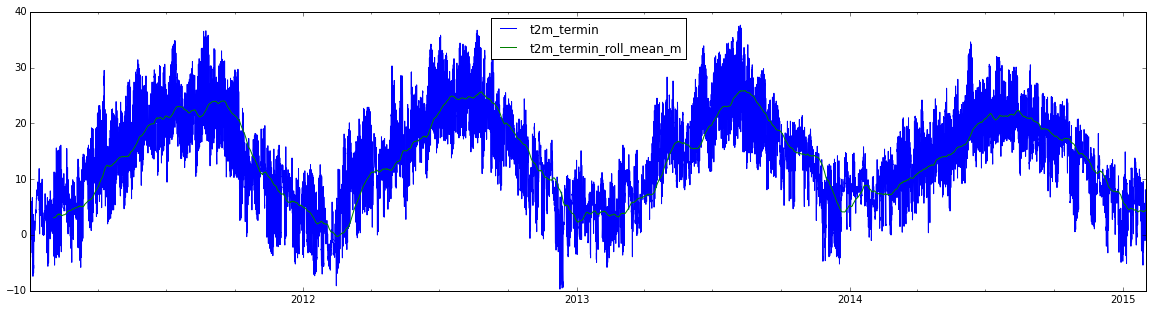

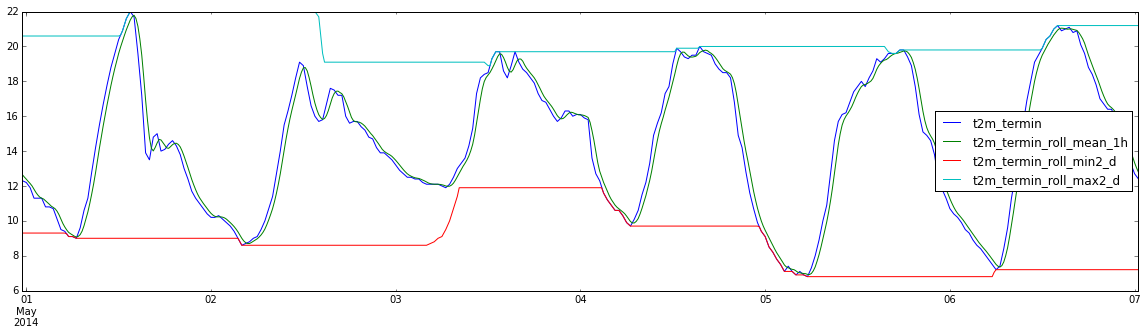

In [15]:
data[['t2m_termin', 't2m_termin_roll_mean_m']].plot(figsize=(20,5))
data['2014-04-30 23:30:00':'2014-05-07 00:30:00'][['t2m_termin','t2m_termin_roll_mean_1h','t2m_termin_roll_min2_d','t2m_termin_roll_max2_d']].plot(figsize=(20,5))

## Adding Aggregates for DateTime

In [16]:
data['BusinessDay_sum'] = pd.rolling_sum(data[['BusinessDay']], window=aggr_interval['w'])
data['Holiday_sum'] = pd.rolling_sum(data[['Holiday']], window=aggr_interval['w'])

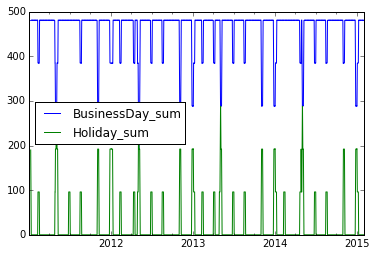

In [17]:
data[['BusinessDay_sum', 'Holiday_sum']].plot()

## Clean Database

Drop NaNs. That is the whole Januray (because of the 1 month moving average).

In [25]:
data.shape

(140350, 445)

In [23]:
data.dropna(inplace=True)

In [26]:
data.shape

(140350, 445)

## Exporting Dataset

In [24]:
output_file_name = "lotOfFeatures.csv"
output_file_name = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

data.to_csv(output_file_name)

## Feature Correlations

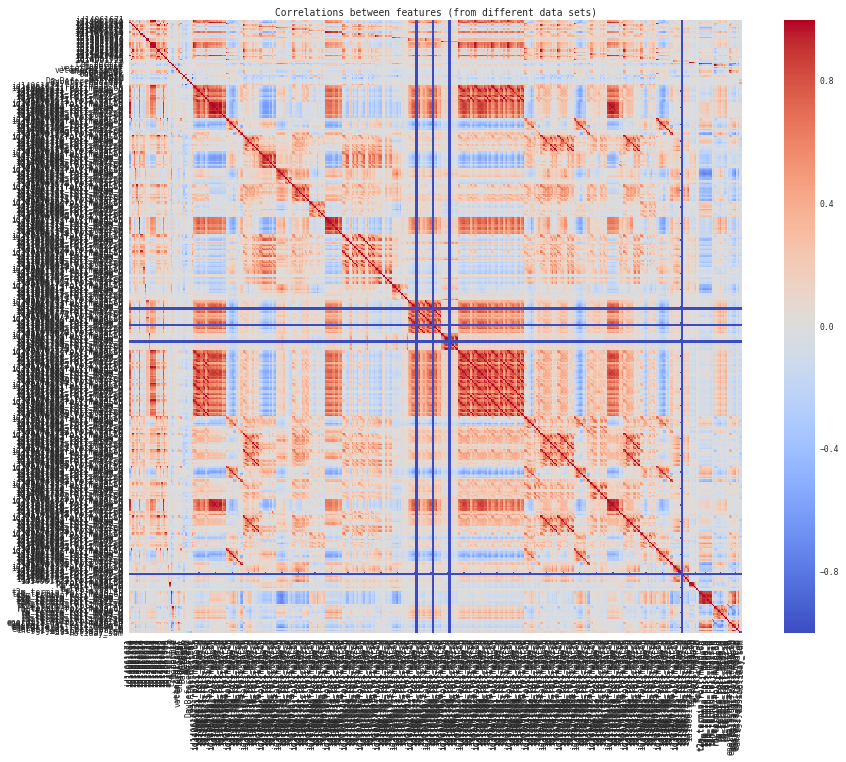

In [21]:
import seaborn as sns
sns.set(context="paper", font="monospace")

corrmat = data.corr()
#corrmat = data['2013-01-07 22:00:00':'2014-01-14 22:00:00'].corr()
#corrmat = data['2014-01-07 22:00:00':'2014-01-14 22:00:00'].corr()

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corrmat, vmax=.8, linewidths=0, cmap="coolwarm", square=True)
#sns.heatmap(corrmat, vmax=.8, linewidths=0, square=True)

plt.title("Correlations between features (from different data sets)")
#f.tight_layout()

#plt.savefig("./figures/correlations.pdf")
#plt.savefig("./figures/correlations.png", dpi=300)